In [1]:
import numpy as np
from pywt import wavedec
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import  graphviz_layout
import networkx as nx
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = [25, 20]     


In [2]:
class Veri():
    ################################################
    def genData(self, param, show = False):
        a=[]
        if param[0]=="normal":
            mu, sigma, s = param[1],   param[2], param[3]
            a= np.random.normal(mu, sigma, size=s)
        elif param[0]=='uniform':
            mi, ma,s=param[1],   param[2], param[3]
            a= np.random.uniform(mi, ma, s)
        elif param[0]=="poisson":
            rate,s=param[1],   param[2]
            a = np.random.poisson(rate, s)
        if(show):
            count, bins, ignored = plt.hist(s, 14, density=True)
        return a
    ################################################
    def genSample(self, signalCount, verbose = False):
        if verbose: print("generate sample data")
        signals = [] 
        for i in range(signalCount):
            a = self.genData(["normal", 100,100,8])
            #print(a)
            sig = [] 
            for j in range(8):
                sig.append(int(a[j]))
            signals.append(sig)
        for i in range(signalCount):
            if verbose: print(signals[i])
        return signals
    ################################################
    def mergeList(self, input_data, verbose= False):
        if verbose:
            print("merge data")
        merged_list = []
        for l in input_data:
            merged_list += list(l)
        return merged_list
    ################################################
    def listToPandasDF(self, input_data):
        df = pd.DataFrame(input_data)
        return df
    ################################################
    def getWaveletCoefs(self, input_data):
        coefs = [] 
        
        girdi = np.array(input_data) #np.array([1,2,3,4,5,6,7,8])*1
        coeff = wavedec(girdi, 'haar', level=int(np.log2(len(girdi))))
        coefs= (self.mergeList(coeff))
        return coefs
    ################################################
    def generateOperationsSymbols(self,operations_count,  Test = False, verbose= False):
        ops_ids=[]
        symbolSet = []

        for i in range(operations_count):
            if(verbose):print(i, end="\t")
            a = self.genData(["uniform", 0,10,4])    
            a= [int(x) for x in a]
            if(Test):
                a[3]=0
            go = True        
            #a=[4, 5, 9, -5]

            rez = 0
            if(int(a[1])%4==0   ): # operation is + 
                if ( a[0] + a[2] > 9 ):
                    go = False
                else :
                    rez = a[0] + a[2]
            elif(int(a[1])%4==1   ): # operation is -
                if a[0] < a[2]  :
                    go = False                
                else :
                    #print("here", a[0] - a[2] , a[0] > a[2])
                    rez = a[0] - a[2]
            elif(int(a[1])%4==2   ): # operation is *
                if ( a[0] * a[2] >9  ):
                    go = False
                else :                
                    rez = a[0] * a[2]               
            elif(int(a[1])%4==3   ): # operation is -
                if ( a[2] ==0 ):                
                    go = False
                else :
                    rez = int(a[0] / a[2])
            #rint(go)  
            if go:
                if verbose : print(go , rez)
                a[3]=rez
                ops_ids.append(a)
                symbolSet.append(self.symbols[a[0]] )
                symbolSet.append(self.symbols[a[1]%4+10] )
                symbolSet.append(self.symbols[a[2]] )
                symbolSet.append(self.symbols[14] )
                if(not Test):
                    symbolSet.append(self.symbols[a[3]] )
                else:
                    symbolSet.append(self.symbols[15] )
        return ops_ids, symbolSet
    ################################################
    def quantize(self, input_data, len_of_data, verbose = False):
        borders = [-200,-100,-50,0, 50, 100, 200]
        qsignals = [] 

        #for i in range(len(input_data)):
        
        sig = [] 
        if(verbose):
            print(input_data)
        for j in range(int(len(input_data))):
            output = 7
            for k in range(7):
                if( input_data[j] < borders[k]):
                    output = k
                    break
            if verbose:
                print(output, end = " ")
            sig.append(output)
        if verbose:
            print()
        qsignals.append(sig)
        return qsignals
    ################################################
    def generateInputData(self,op_count , verbose = False):    
        encoded, symbol_based= self.generateOperationsSymbols(op_count, False, verbose)    
        if(verbose):
            print("operation symbols")
            [print(i, symbol_based[i]) for i in range(len(symbol_based))]
            print()
        return symbol_based
    ################################################
    def addNoise(self, data, noise_mean, noise_std):
        return data
    ################################################
    def __init__(self):
        self.symbols= self.genSample(16)
    


In [86]:
class Spek:   
    # initialize a tree with a root node
    ################################################
    def initTree(self):
        GG=nx.DiGraph()    
        GG.add_node(0, value=99999,occurance_count=1, id = -1,food =0)    
        return GG,1
    ################################################
    def train_tree(self,input_data, GG, counter , WL, overlap):
        plt.rcParams.update({'font.size': 22})
        data1= input_data  
        #print(data1)
        poz = 0
        #print(len(data1)/WL)    
        step = WL-overlap

        for i in range(0,len(data1)-step+1, step):
            #if(data1[i:i+step]==[0,0,1,0] or  data1[i:i+step]==[1,0,0,0] ):
            #    //print(str(i)+ " food")
            poz=0
            for j in range(WL):
                # data
                d=data1[i + j]
                #print(d, end=' ')
                #print (d)
                # neighbours 
                nei= list(GG.neighbors(poz))       
                if len(nei)==0:
                    #print (counter, poz, data1[i: i+step])
                    GG.add_node(counter,value=d, occurance_count=1, id = -1,food =0)    
                    GG.add_edge(poz,counter)
                    poz=counter
                    counter +=1
                else:
                    k=-1
                    for n in nei:
                        if(GG.node[n]['value']==d):
                            k=n
                            break
                    if(k>=0):
                        poz=k
                        GG.node[k]['occurance_count'] = GG.node[k]['occurance_count'] + 1
                    else:
                        GG.add_node(counter,value=d,occurance_count=1, id = -1,food =0)    
                        GG.add_edge(poz,counter)
                        poz=counter
                        counter += 1
        finalNodes = [] 
        for i in range(1, counter):
            yol =  nx.shortest_path(GG,0,i)
            if(len(yol) >WL):
                GG.node[yol[-1]]['id']=len(finalNodes)
                finalNodes.append(yol[-1])
        return GG, counter
    ################################################
    def addBranches(self,GG,ops,counter,WL, overlap=0, doPlot = False):    
        GG,counter = self.train_tree( (self.v.mergeList(ops)), GG, counter , WL, overlap)
        if doPlot:
            plotGraph(GG,WL,counter)
        return GG, counter
    ################################################
    def plotGraph(self,GG, WL, counter, short = False):
        plt.rcParams['figure.figsize'] = [15, 10]        
        labels=dict((n,round(d['value'],2)) for n,d in GG.nodes(data=True))   
        #pos=nx.graphviz_layout(GG, prog='dot')
        pos =graphviz_layout(GG, prog='dot')
        #nx.spring_layout(GG)

        plt.title("node values")
        nx.draw_networkx(GG,  pos=pos, arrows=True, with_labels=True, labels=labels )
        plt.show()
        if( short):
            return
        plt.title("node ids")
        nx.draw_networkx(GG,  pos=pos, arrows=True, with_labels=True )
        plt.show()

        plt.title("node frequency")
        labels=dict((n,d['occurance_count']) for n,d in GG.nodes(data=True))   
        nx.draw_networkx(GG,  pos=pos, arrows=True, with_labels=True, labels=labels )
        plt.show()



        plt.title("final nodes ids")
        labels=dict((n,d['id']) for n,d in GG.nodes(data=True))   
        nx.draw_networkx(GG,  pos=pos, arrows=True, with_labels=True, labels=labels )
        plt.show()    
        
    ################################################    
    def getBranchId(self, branch,GG, counter , WL, overlap):    
        ids = []
        plt.rcParams.update({'font.size': 22})
        data1= branch  
        #print (data1)
        poz = 0
        #print(len(data1)/WL)    
        step = WL-overlap

        for i in range(0,len(data1)-step+1, step):
            k=0
            poz=0
            #print()
            for j in range(WL):
                # data
                d=data1[i + j]

                # neighbours 
                nei= list(GG.neighbors(poz))       
                if len(nei)==0:
                    k=-1
                    break
                else:
                    k=-1
                    for n in nei:
                        if(GG.node[n]['value']==d):
                            k=n
                            break
                    if(k>=0):
                        poz=k                    
                        #GG.node[k]['occurance_count'] = GG.node[k]['occurance_count'] + 1
                    else:
                        k=-1
                        break
            #ids.append(k)

            #ids.append(GG.node[k]['id'])
            if(k>0):
                ids.append(GG.node[k]['id'])
            else:
                ids.append(-1)
        return ids
    ################################################
    def getBranchGivenStartNodeValue(self, startNodeValue,GG):    
        data = [] 
        nei= list(GG.neighbors(0))      
        #print(nei)
        k=-1
        for n in nei:
            if(GG.node[n]['value']==startNodeValue):
                k=n
                break
        #print(k)
        #data.append(k)

        while(k>=0):
            nei= list(GG.neighbors(k))    
            if len(nei)==0:
                k=-1
            else:
                k=nei[0]
                data.append(GG.node[k]['value'])
        return data
    ################################################
    def getBranchIDsGivenStartNodeValue(self, startNodeValue,GG):    
        data = [] 
        nei= list(GG.neighbors(0))      
        #print(nei)
        k=-1
        for n in nei:
            if(GG.node[n]['value']==startNodeValue):
                k=n
                break
        #print(k)
        #data.append(k)

        while(k>=0):
            nei= list(GG.neighbors(k))    
            if len(nei)==0:
                k=-1
            else:
                k=nei[0]
                #data.append(GG.node[k]['value'])
                data.append(k)
        return data
    ################################################
    def checkBranch(self, branch,GG, counter , WL, overlap):    
        ids = []
        plt.rcParams.update({'font.size': 22})
        data1= branch  
        #print (data1)
        poz = 0
        #print(len(data1)/WL)    
        step = WL-overlap

        for i in range(0,len(data1)-step+1, step):
            k=0
            poz=0
            #print()
            j=0
            # data
            d=data1[i + j]

            # neighbours 
            nei= list(GG.neighbors(poz))       
            if len(nei)==0:
                k=-1
                break
            else:
                k=-1
                for n in nei:
                    if(GG.node[n]['value']==d):
                        k=n
                        break
                if(k>=0):
                    poz=k                    
                    #GG.node[k]['occurance_count'] = GG.node[k]['occurance_count'] + 1
                else:
                    k=-1
                    break
            #ids.append(k)

            #ids.append(GG.node[k]['id'])
            if(k>0):
                ids.append(GG.node[k]['value'])
            else:
                ids.append(-1)
        return ids
    ################################################
    def preprocess(self,symbol_data):       
        c= ( self.v.getWaveletCoefs(symbol_data))
        #print(c)
        quantized_input=self.v.quantize(c,len_of_data=8)
        return quantized_input
    ################################################
    def generateInputData(self, op_count , verbose = False):    
        x = self.v.generateInputData(op_count, verbose)
        x=self.v.addNoise(x, noise_mean=0, noise_std=0)
        if(verbose):
            print(x)
        return x
    ################################################
    def learnInputData(self, raw_data,train = False, verbose= False):
        addBranch=True
        if(verbose): print("raw data: ", raw_data)
        
        qdata = self.preprocess(raw_data)
        
        if(verbose): print("preprocessed data: ",qdata)
        
        if addBranch: self.AbstractTree,self.counterAbstract = self.addBranches(self.AbstractTree,qdata,self.counterAbstract,WL=8, overlap=0, doPlot=False)

        abid= self.getBranchId(qdata[0],self.AbstractTree, self.counterAbstract , WL=8, overlap=0)
        
        if(verbose): print("Abstract leaf id: ",abid)
        
        if addBranch: self.ContextTree,self.counterContext = self.addBranches(self.ContextTree,[abid],self.counterContext,WL=1, overlap=0, doPlot=False)
        
        cbid= self.getBranchId(abid,self.ContextTree, self.counterContext , WL=1, overlap=0)
        
        if(verbose):print("Context  leaf id: ",cbid)
        
        foundNode = self.checkBranch(cbid,self.ActuatorTree, self.counterContext , WL=1, overlap=0)
        
        if(verbose): print("Actuator branch found ",foundNode)
        
        if len(foundNode) ==0 and addBranch:
            sample_sound= self.v.mergeList( [cbid, (self.v.genSample(1,True)[0])])
            self.ActuatorTree,self.counterActuator = self.addBranches(self.ActuatorTree, [sample_sound] ,self.counterActuator,WL=9, overlap=0, doPlot=False)
            foundNode = self.checkBranch(cbid,self.ActuatorTree, self.counterContext , WL=1, overlap=0)
        else:
            if(verbose):print("node exists in actuator, check error")
        
        nodes = self.getBranchGivenStartNodeValue(foundNode[0],self.ActuatorTree)
        
        if(verbose):print("branch before",nodes)
        
        nodes = self.getBranchIDsGivenStartNodeValue(foundNode[0],self.ActuatorTree)
        if(train):
            for j in range(self.loopCount):
                for i in range(len(nodes)):
                    #print (i, branch[i] , GG.node[nodes[i]]['value'])
                    self.ActuatorTree.node[nodes[i]]['value']+=  round(( raw_data[i]-self.ActuatorTree.node[nodes[i]]['value'] )*self.learningRate, 2)
        nodes = self.getBranchGivenStartNodeValue(foundNode[0],self.ActuatorTree)
        if(verbose):print("branch after",nodes)
    
    ################################################
    def getSolutionToData(self, raw_data, verbose= False):
        
        if(verbose): print("raw data: ", raw_data)
        
        qdata = self.preprocess(raw_data)
        
        if(verbose): print("preprocessed data: ",qdata)
        
        abid= self.getBranchId(qdata[0],self.AbstractTree, self.counterAbstract , WL=8, overlap=0)
        
        if(verbose): print("Abstract leaf id: ",abid)
        
        cbid= self.getBranchId(abid,self.ContextTree, self.counterContext , WL=1, overlap=0)
        
        if(verbose):print("Context  leaf id: ",cbid)
        
        foundNode = self.checkBranch(cbid,self.ActuatorTree, self.counterContext , WL=1, overlap=0)
        
        if(verbose): print("Actuator branch found ",foundNode)        
        
        if len(foundNode) ==0:   return []            
        else: 
            if(verbose):print("node exists in actuator, check error")
        
        nodes = self.getBranchGivenStartNodeValue(foundNode[0],self.ActuatorTree)
        
        if(verbose):print("branch ",nodes)        
        return nodes
    
    ################################################
    def displayTrees(self):
        self.plotGraph(self.AbstractTree,8, self.counterAbstract, short = True)
        self.plotGraph(self.ContextTree,8, self.counterContext, short = True)
        self.plotGraph(self.ActuatorTree,8, self.counterActuator, short = True)
    ################################################
    def printTrees(self):
        print("Abstract")
        for line in nx.generate_edgelist(self.AbstractTree, data=False):
                print(line)
        print("Context")
        for line in nx.generate_edgelist(self.ContextTree, data=False):
                print(line)
        print("Actuator")
        for line in nx.generate_edgelist(self.ActuatorTree, data=False):
                print(line)
    
    
    
    
    ################################################
    def __init__(self):
        
        self.v= Veri()
        
        self.WLAbstract = 8 # window length
        self.overlapAbstract = 0# int(WL/5)
        self.AbstractTree,self.counterAbstract = self.initTree()

        self.ContextTree, self.counterContext = self.initTree()
        self.ActuatorTree,self.counterActuator = self.initTree()
        self.learningRate = 0.05
        self.loopCount = 10


## Initialize a spektron with a specific alphabet

In [99]:
s = Spek()
s.v.symbols
symbols_correspondence = ["0","1","2","3","4","5","6","7","8","9","+", "-","*", "/","=","?"]
print("indice", "symbol", "pattern")
[print(i,"\t",symbols_correspondence[i],"\t", s.v.symbols[i]) for i in range(len(s.v.symbols))]
print()

indice symbol pattern
0 	 0 	 [9, 256, 62, 359, 51, 82, 14, 45]
1 	 1 	 [9, 70, 87, 40, 230, 88, 158, 157]
2 	 2 	 [218, -72, 100, -43, 89, 193, 67, 77]
3 	 3 	 [236, 183, 157, 264, 27, 93, -215, 247]
4 	 4 	 [98, 204, 156, 249, 30, 90, 228, 116]
5 	 5 	 [156, 125, 60, 209, 34, 116, 103, -39]
6 	 6 	 [185, 342, 199, -5, 171, 54, 84, 73]
7 	 7 	 [68, -53, -50, 58, 288, 108, -17, -178]
8 	 8 	 [43, 193, 79, 58, 331, 100, 61, 153]
9 	 9 	 [123, -28, -66, 195, 172, 60, 23, -28]
10 	 + 	 [127, 36, 123, 100, 228, -129, 135, 131]
11 	 - 	 [109, 131, 151, 8, -33, -69, 82, -74]
12 	 * 	 [-111, 137, -14, 149, 62, 124, 61, 109]
13 	 / 	 [69, 333, 161, -52, 22, 150, -27, 124]
14 	 = 	 [228, -93, -51, -75, 10, 247, 125, 110]
15 	 ? 	 [11, 18, -88, 14, 153, -26, 129, 176]



## Generate Input Operations

In [104]:
raw_input = s.generateInputData(2,False)
[print(i, raw_input[i]) for i in range(len(raw_input))]
print()

0 [43, 193, 79, 58, 331, 100, 61, 153]
1 [109, 131, 151, 8, -33, -69, 82, -74]
2 [156, 125, 60, 209, 34, 116, 103, -39]
3 [228, -93, -51, -75, 10, 247, 125, 110]
4 [236, 183, 157, 264, 27, 93, -215, 247]
5 [236, 183, 157, 264, 27, 93, -215, 247]
6 [-111, 137, -14, 149, 62, 124, 61, 109]
7 [236, 183, 157, 264, 27, 93, -215, 247]
8 [228, -93, -51, -75, 10, 247, 125, 110]
9 [123, -28, -66, 195, 172, 60, 23, -28]



## Pass the operations and generate random responses

In [106]:
#print(raw_input[0])
#s.preprocess(raw_input[1]))
for i in range(len(raw_input)):
    s.learnInputData(raw_input[i],train=False,verbose=False)

generate sample data
[-84, 119, -124, -43, 48, 66, 57, 102]
generate sample data
[272, 305, 20, 190, 226, 121, 124, 126]
generate sample data
[86, 127, 85, 185, 6, 151, 182, -19]
generate sample data
[214, 154, 24, 151, 75, 275, -30, 142]
generate sample data
[81, -24, 65, 37, 152, -112, 260, 78]
generate sample data
[-41, 107, 26, 52, 54, 81, -110, 82]
generate sample data
[134, 59, -76, 90, 206, 88, 101, 76]


## Display the tree

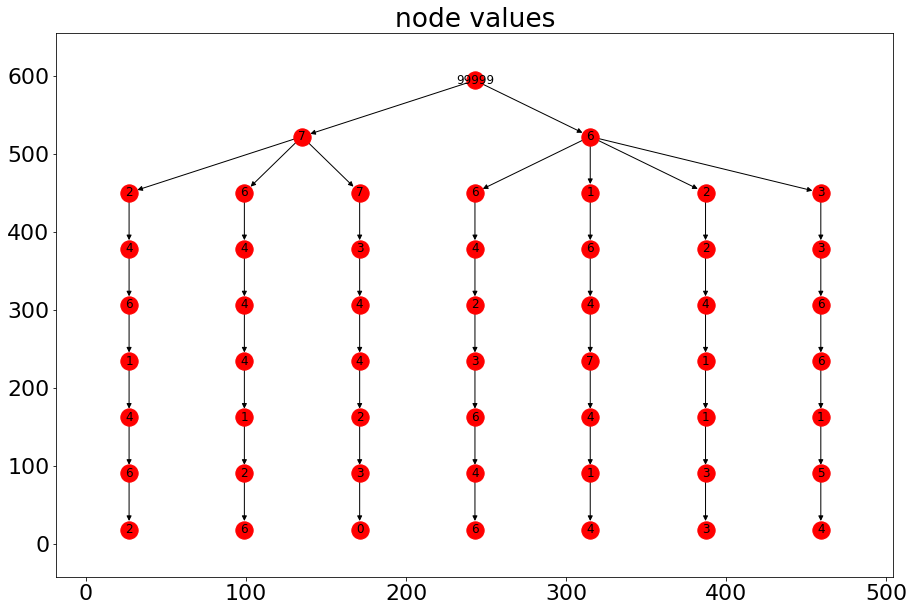

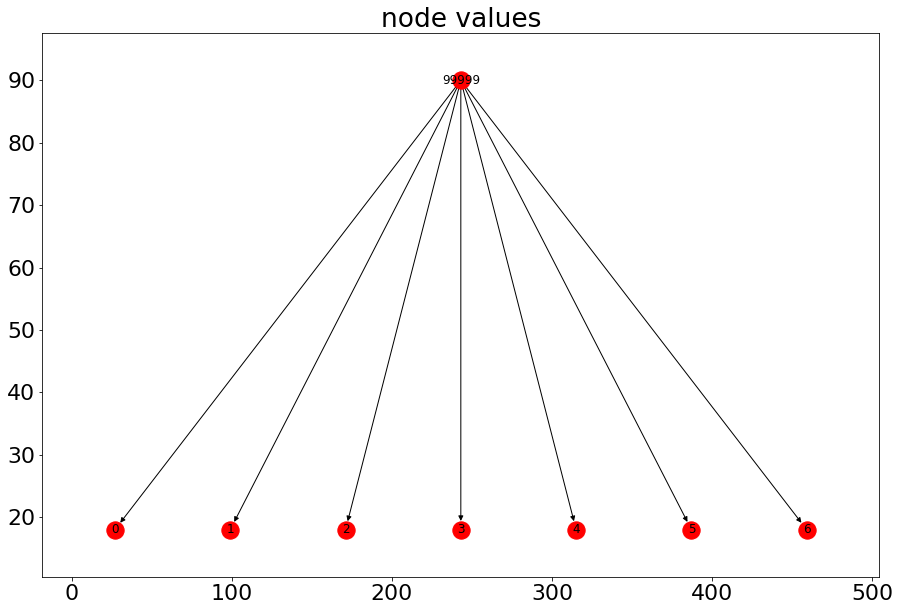

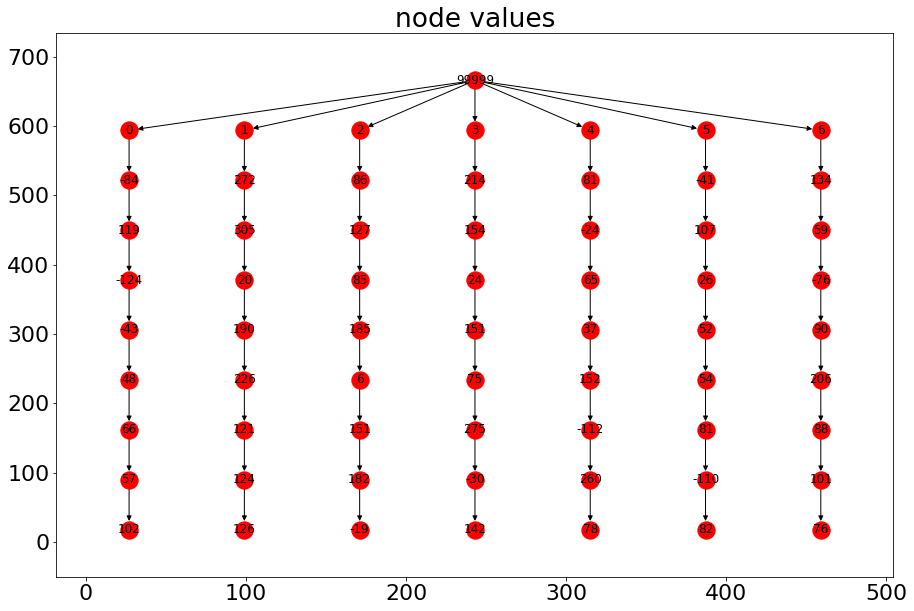

In [107]:
s.displayTrees()

In [91]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## Plot  the raw input vs Actuator's response for one input

raw data:  [43, 193, 79, 58, 331, 100, 61, 153]
preprocessed data:  [[7, 2, 4, 6, 1, 4, 6, 2]]
Abstract leaf id:  [0]
Context  leaf id:  [0]
Actuator branch found  [0]
node exists in actuator, check error
branch  [-84, 119, -124, -43, 48, 66, 57, 102]
RMSE= 140.03437078089078


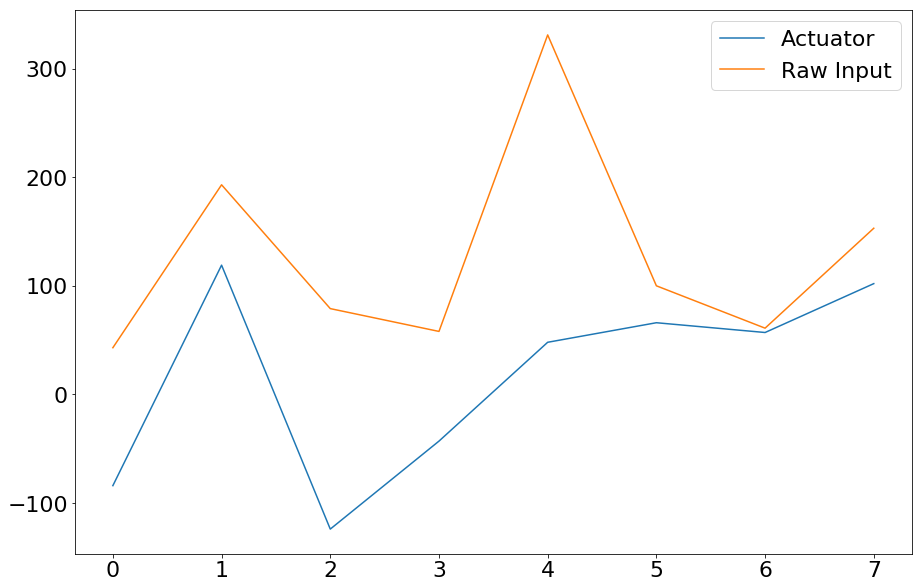

In [108]:
x=s.getSolutionToData(raw_input[0],True )
plt.plot(x)
plt.plot((raw_input[0] ))
plt.legend(["Actuator","Raw Input"])

print("RMSE=", rmse(np.array(raw_input[0]), np.array(x)))
         

## Train a little the system with the same operations and display the raw input vs new 

RMSE= 83.84542459192393


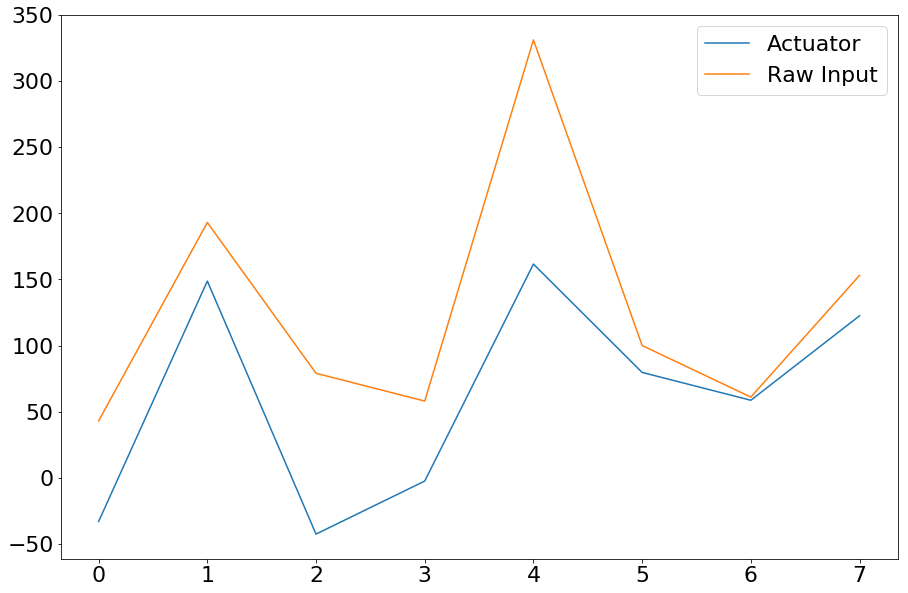

In [109]:
for i in range(len(raw_input)):
    s.learnInputData(raw_input[i],train=True,verbose=False)

x=s.getSolutionToData(raw_input[0] )
plt.plot(x)
plt.plot((raw_input[0] ))
plt.legend(["Actuator","Raw Input"])         

print("RMSE=", rmse(np.array(raw_input[0]), np.array(x)))

## Train a little more the system with the same operations and display the raw input vs new 

RMSE= 55.15561077533275


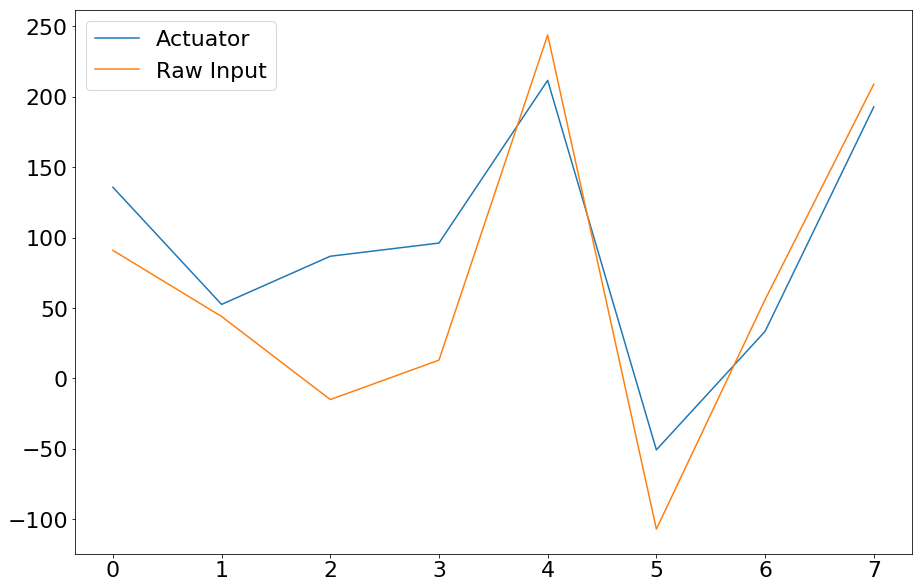

In [94]:
for i in range(len(raw_input)):
    s.learnInputData(raw_input[i],train=True,verbose=False)

x=s.getSolutionToData(raw_input[0] )
plt.plot(x)
plt.plot((raw_input[0] ))
plt.legend(["Actuator","Raw Input"])         

print("RMSE=", rmse(np.array(raw_input[0]), np.array(x)))

## Train a little little more the system with the same operations and display the raw input vs new 

RMSE= 33.02323821947206


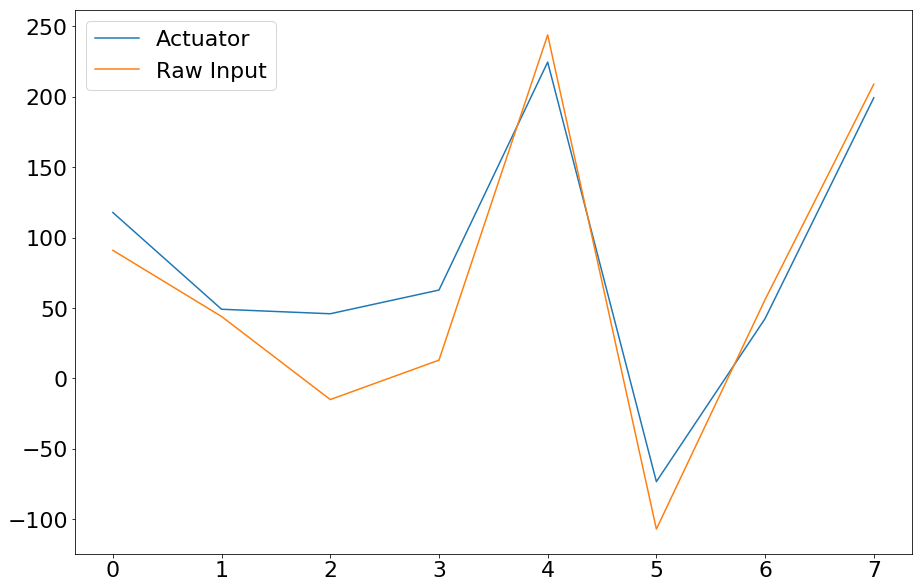

In [95]:
for i in range(len(raw_input)):
    s.learnInputData(raw_input[i],train=True,verbose=False)

x=s.getSolutionToData(raw_input[0] )
plt.plot(x)
plt.plot((raw_input[0] ))
plt.legend(["Actuator","Raw Input"])         

print("RMSE=", rmse(np.array(raw_input[0]), np.array(x)))

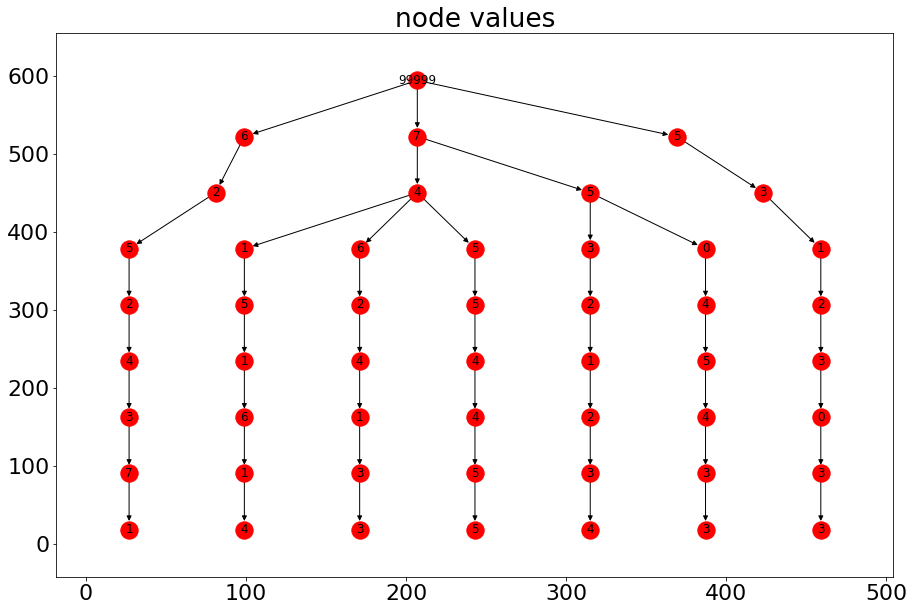

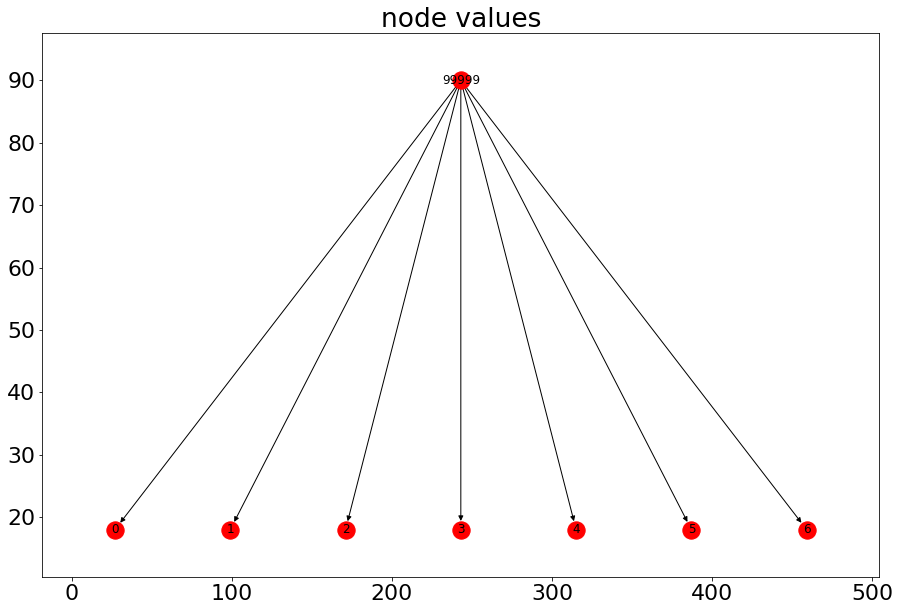

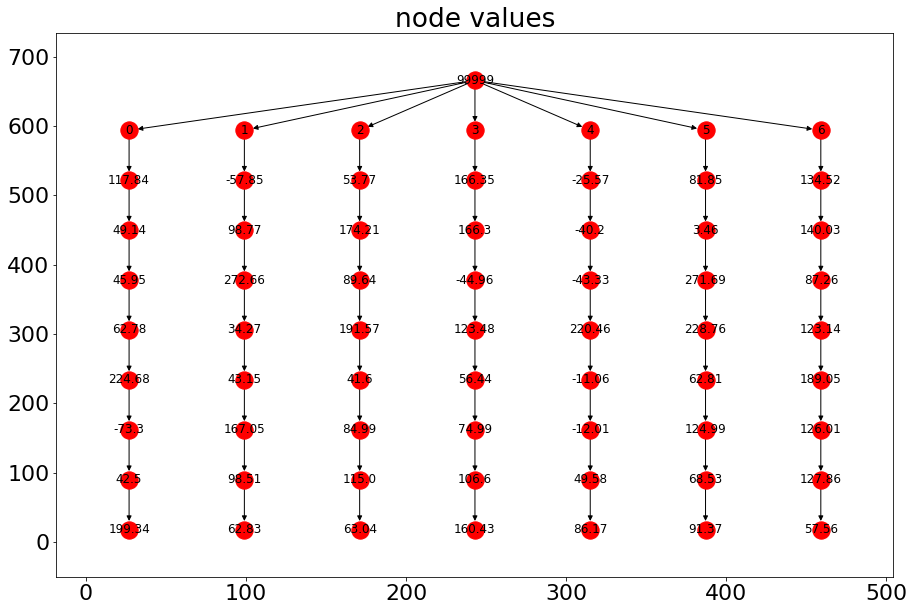

In [96]:
s.displayTrees()

In [81]:
GG=nx.DiGraph()

GG.add_node(0, value=99)
GG.add_node(1, value=1)
GG.add_node(2, value=31)
GG.add_node(3, value=41)
GG.add_node(4, value=41)
GG.add_node(5, value=41)

GG.add_edge(0,1)
GG.add_edge(1,2)
GG.add_edge(2,3)
GG.add_edge(3,4)
GG.add_edge(4,5)

def getBranchGivenStartNodeValue(startNodeValue,GG):    
    data = [] 
    nei= list(GG.neighbors(0))      
    #print(nei)
    k=-1
    for n in nei:
        if(GG.node[n]['value']==startNodeValue):
            k=n
            break
    #print(k)
    #data.append(k)

    while(k>=0):
        nei= list(GG.neighbors(k))    
        if len(nei)==0:
            k=-1
        else:
            #k=nei[0]
            data.append(GG.node[k]['value'])
            data.append(k)
    return data

def getBranchIDsGivenStartNodeValue(startNodeValue,GG):    
    data = [] 
    nei= list(GG.neighbors(0))      
    #print(nei)
    k=-1
    for n in nei:
        if(GG.node[n]['value']==startNodeValue):
            k=n
            break
    #print(k)
    #data.append(k)

    while(k>=0):
        nei= list(GG.neighbors(k))    
        if len(nei)==0:
            k=-1
        else:
            k=nei[0]
            #data.append(GG.node[k]['value'])
            data.append(k)
    return data

In [82]:
G=GG.copy()

In [83]:
nodes = getBranchIDsGivenStartNodeValue(1,GG)
branch = [10,0,50,100]
print(nodes)

[2, 3, 4, 5]


In [84]:
for j in range(10):
    for i in range(len(nodes)):
        #print (i, branch[i] , GG.node[nodes[i]]['value'])
        GG.node[nodes[i]]['value']+= ( branch[i]-GG.node[nodes[i]]['value'] )*0.2
err = 0
for i in range(len(nodes)):
    err+= abs(branch[i]-GG.node[nodes[i]]['value'] )
print(err)

13.958643711999994


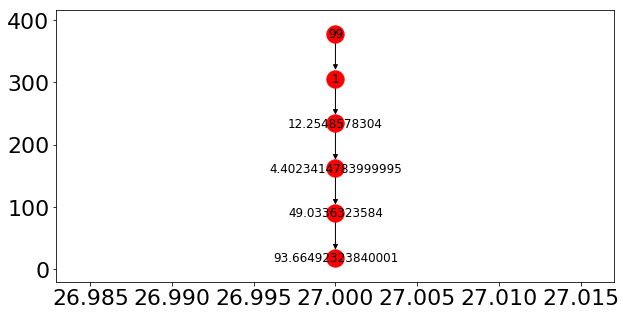

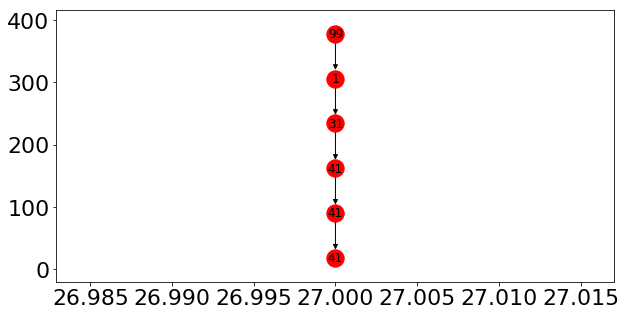

In [85]:
plt.rcParams['figure.figsize'] = [10, 5]     
labels=dict((n,d['value']) for n,d in GG.nodes(data=True))   
pos =graphviz_layout(GG, prog='dot')
#nx.draw_networkx(GG,pos=pos,arrows=True, with_labels=True)
#plt.show()
nx.draw_networkx(GG,pos=pos,arrows=True, with_labels=True, labels=labels ) 
plt.show()
labels=dict((n,d['value']) for n,d in G.nodes(data=True))  
nx.draw_networkx(G,pos=pos,arrows=True, with_labels=True, labels=labels ) 




# 